# TASK #2: IMPORT LIBRARIES AND DATASETS

In [7]:
# Configuration and paths
import os
from pathlib import Path

# Set base directory
BASE_DIR = Path.cwd()
DATA_DIR = '../data/'
MODELS_DIR = '../models/'


# Configuration constants
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
IMAGE_SIZE = (256, 256)
EPOCHS = 100

# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_auc_score,RocCurveDisplay, precision_score, f1_score
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob
import random
%matplotlib inline

In [8]:
brain_df = pd.read_csv('../data/route_label.csv', index_col=0)

# DATA

In [9]:
# Get the dataframe containing MRIs which have masks associated with them.
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.to_csv(DATA_DIR +"segmentation_routes_labels.csv")
brain_df_mask.shape

(1366, 3)

In [10]:
# split the data into train and test data

from sklearn.model_selection import train_test_split

brain_df_mask_train, brain_df_mask_val = train_test_split(brain_df_mask, test_size=0.2,random_state=42)
brain_df_mask_test, brain_df_mask_val = train_test_split(brain_df_mask_val, test_size=0.5,random_state=42)

In [11]:
# Save train/test/val splits to data directory
brain_df_mask_train.to_csv(DATA_DIR+ "segmentation_train.csv")
brain_df_mask_test.to_csv(DATA_DIR+"segmentation_test.csv")
brain_df_mask_val.to_csv(DATA_DIR +"segmentation_validation.csv")

In [12]:
BATCH_SIZE = 16

In [13]:
# Seed for synchronizing image and mask augmentations
SEED = 42

# Generator WITH augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generator WITHOUT augmentation for validation/test
val_datagen = ImageDataGenerator(rescale=1./255.)

In [14]:
def train_generator_fn():
    """Training generator with synchronized augmentation for image and mask."""
    image_generator = train_datagen.flow_from_dataframe(
        brain_df_mask_train,
        x_col='image_path',
        class_mode=None,
        color_mode="rgb",
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        seed=SEED,  # Same seed for synchronization
        shuffle=True
    )

    mask_generator = train_datagen.flow_from_dataframe(
        brain_df_mask_train,
        x_col="mask_path",
        class_mode=None,
        color_mode="grayscale",
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        seed=SEED,  # Same seed - ensures identical transformations
        shuffle=True
    )

    while True:
        img = next(image_generator)
        msk = next(mask_generator)
        # Binarize masks (augmentation can create intermediate values)
        msk = (msk > 0.5).astype(np.float32)
        yield (img, msk)

training_generator = train_generator_fn()


def val_generator_fn():
    """Validation generator WITHOUT augmentation."""
    image_generator_val = val_datagen.flow_from_dataframe(
        brain_df_mask_val,
        x_col='image_path',
        class_mode=None,
        color_mode="rgb",
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        seed=SEED,
        shuffle=False  # No shuffle for validation
    )

    mask_generator_val = val_datagen.flow_from_dataframe(
        brain_df_mask_val,
        x_col="mask_path",
        class_mode=None,
        color_mode="grayscale",
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        seed=SEED,
        shuffle=False
    )

    while True:
        img = next(image_generator_val)
        msk = next(mask_generator_val)
        # Binarize masks
        msk = (msk > 0.5).astype(np.float32)
        yield (img, msk)

validation_generator = val_generator_fn()


In [15]:
def resblock(X, f):


  # make a copy of input
  X_copy = X

  # main path
  # Read more about he_normal: https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528

  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short path
  # Read more here: https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [16]:
# function to upscale and concatenate the values passsed
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [17]:
input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )


In [18]:
model_seg.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │        544 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │        544 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ add[0][0]         │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │      2,112 │ max_pooling2d_1[

 Total params: 1,210,513 (4.62 MB)

 Trainable params: 1,206,129 (4.60 MB)

 Non-trainable params: 4,384 (17.12 KB)

In [19]:
LEARNING_RATE = 1e-4
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth
    )

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dl = dice_loss(y_true, y_pred)
    return bce + dl

def iou_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    total = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    union = total - intersection
    return (intersection + smooth) / (union + smooth)

model_seg.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
              loss=bce_dice_loss,
              metrics=[dice_coef, iou_coef, 'accuracy'])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("segmentation_ResUNet7.keras", save_best_only=True, monitor='val_loss', mode='min', verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
]

steps_per_epoch_calc = len(brain_df_mask_train) // BATCH_SIZE
validation_steps_calc = len(brain_df_mask_val) // BATCH_SIZE

history = model_seg.fit(
    training_generator, # Use the direct Python generator
    steps_per_epoch=steps_per_epoch_calc,
    epochs=EPOCHS,
    validation_data=validation_generator, # Use the direct Python generator
    validation_steps=validation_steps_calc,
    callbacks=callbacks)


Found 0 validated image filenames.
Found 0 validated image filenames.
Epoch 1/100


c:\Users\jolup\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\legacy\preprocessing\image.py:918: UserWarning: Found 1092 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(
c:\Users\jolup\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\legacy\preprocessing\image.py:918: UserWarning: Found 1092 invalid image filename(s) in x_col="mask_path". These filename(s) will be ignored.
  warnings.warn(


InvalidArgumentError: Graph execution error:

Detected at node functional_1/batch_normalization_1/add defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\Users\jolup\AppData\Local\Programs\Python\Python313\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "c:\Users\jolup\AppData\Local\Programs\Python\Python313\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "c:\Users\jolup\AppData\Local\Programs\Python\Python313\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "c:\Users\jolup\AppData\Local\Programs\Python\Python313\Lib\site-packages\tornado\platform\asyncio.py", line 211, in start

  File "c:\Users\jolup\AppData\Local\Programs\Python\Python313\Lib\asyncio\base_events.py", line 683, in run_forever

  File "c:\Users\jolup\AppData\Local\Programs\Python\Python313\Lib\asyncio\base_events.py", line 2050, in _run_once

  File "c:\Users\jolup\AppData\Local\Programs\Python\Python313\Lib\asyncio\events.py", line 89, in _run

  File "c:\Users\jolup\AppData\Local\Programs\Python\Python313\Lib\site-packages\ipykernel\kernelbase.py", line 519, in dispatch_queue

  File "c:\Users\jolup\AppData\Local\Programs\Python\Python313\Lib\site-packages\ipykernel\kernelbase.py", line 508, in process_one

  File "c:\Users\jolup\AppData\Local\Programs\Python\Python313\Lib\site-packages\ipykernel\kernelbase.py", line 400, in dispatch_shell

  File "c:\Users\jolup\AppData\Local\Programs\Python\Python313\Lib\site-packages\ipykernel\ipkernel.py", line 368, in execute_request

  File "c:\Users\jolup\AppData\Local\Programs\Python\Python313\Lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request

  File "c:\Users\jolup\AppData\Local\Programs\Python\Python313\Lib\site-packages\ipykernel\ipkernel.py", line 462, in do_execute

  File "c:\Users\jolup\AppData\Local\Programs\Python\Python313\Lib\site-packages\ipykernel\zmqshell.py", line 577, in run_cell

  File "c:\Users\jolup\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\interactiveshell.py", line 2898, in run_cell

  File "c:\Users\jolup\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\interactiveshell.py", line 2944, in _run_cell

  File "c:\Users\jolup\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner

  File "c:\Users\jolup\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\interactiveshell.py", line 3169, in run_cell_async

  File "c:\Users\jolup\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\interactiveshell.py", line 3361, in run_ast_nodes

  File "c:\Users\jolup\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code

  File "C:\Users\jolup\AppData\Local\Temp\ipykernel_25872\3367946858.py", line 39, in <module>

  File "c:\Users\jolup\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\jolup\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 399, in fit

  File "c:\Users\jolup\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 241, in function

  File "c:\Users\jolup\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 154, in multi_step_on_iterator

  File "c:\Users\jolup\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 125, in wrapper

  File "c:\Users\jolup\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 134, in one_step_on_data

  File "c:\Users\jolup\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 59, in train_step

  File "c:\Users\jolup\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\jolup\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\layer.py", line 941, in __call__

  File "c:\Users\jolup\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\jolup\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\ops\operation.py", line 59, in __call__

  File "c:\Users\jolup\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\jolup\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\models\functional.py", line 183, in call

  File "c:\Users\jolup\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\ops\function.py", line 206, in _run_through_graph

  File "c:\Users\jolup\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\models\functional.py", line 644, in call

  File "c:\Users\jolup\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\jolup\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\layer.py", line 941, in __call__

  File "c:\Users\jolup\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\jolup\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\ops\operation.py", line 59, in __call__

  File "c:\Users\jolup\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\jolup\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py", line 257, in call

Incompatible shapes: [16] vs. [3]
	 [[{{node functional_1/batch_normalization_1/add}}]] [Op:__inference_multi_step_on_iterator_22369]

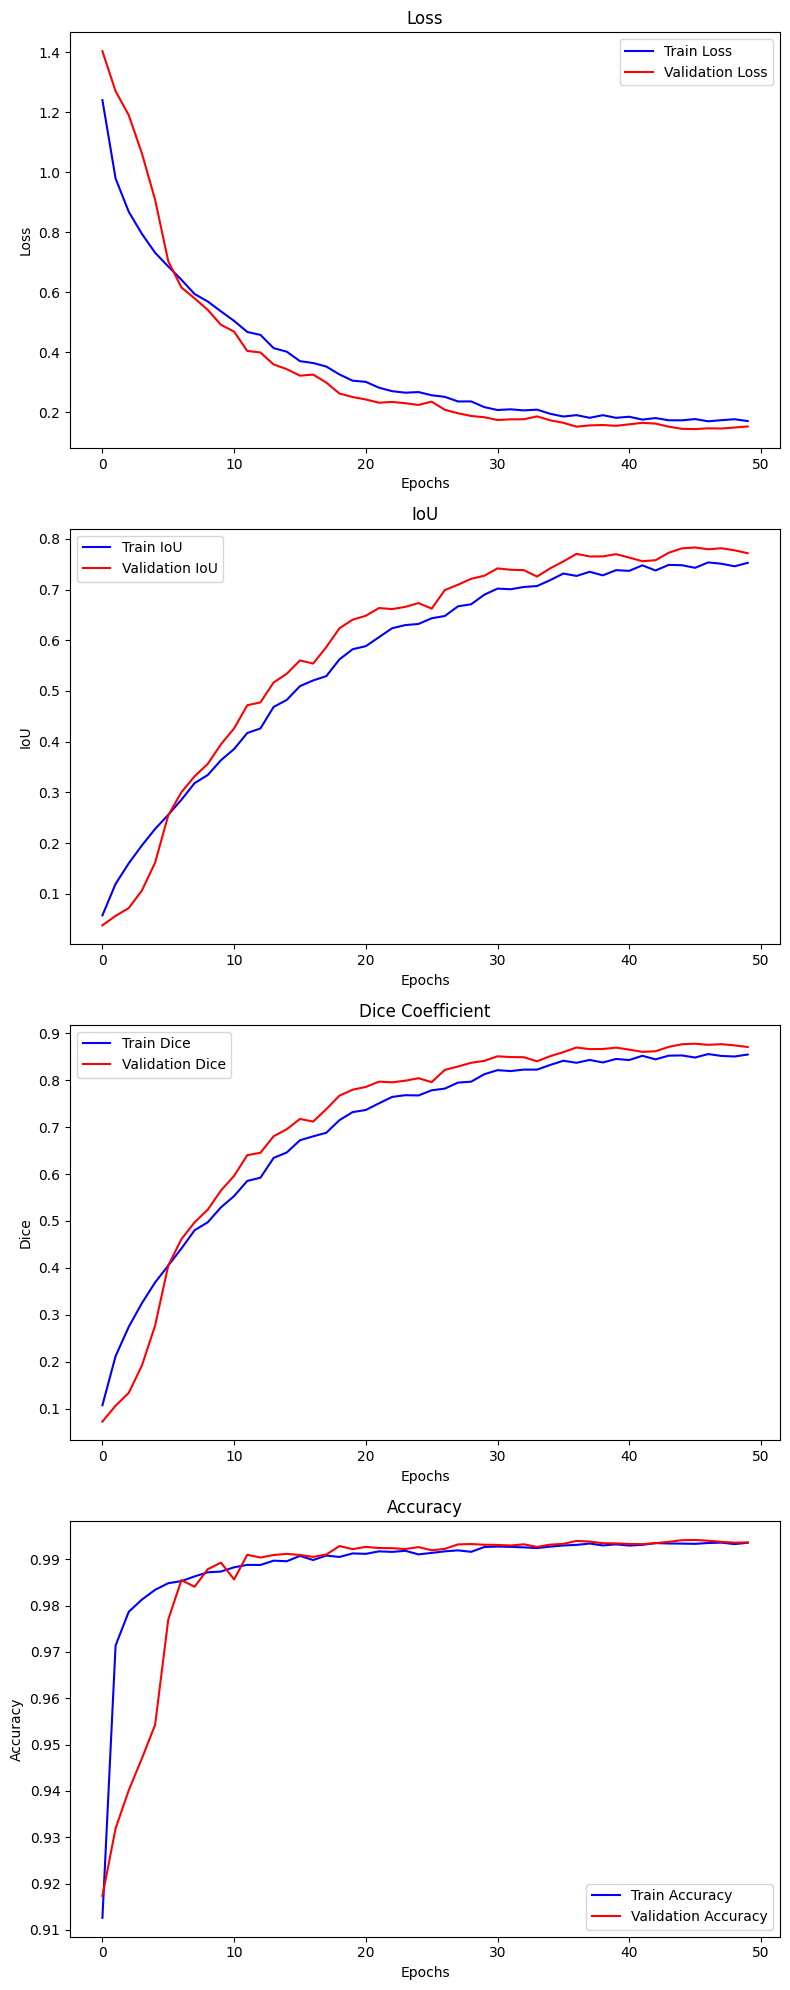

In [ ]:
# Evaluation Visualization
plt.figure(figsize=(8, 20))

# --- Loss ---
plt.subplot(4, 1, 1)
plt.plot(history.history['loss'], 'b-', label='Train Loss')
plt.plot(history.history['val_loss'], 'r-', label='Validation Loss')
plt.legend(loc='best')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# --- IoU ---
plt.subplot(4, 1, 2)
plt.plot(history.history['iou_coef'], 'b-', label='Train IoU')
plt.plot(history.history['val_iou_coef'], 'r-', label='Validation IoU')
plt.legend(loc='best')
plt.title('IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')

# --- Dice Coefficient ---
plt.subplot(4, 1, 3)
plt.plot(history.history['dice_coef'], 'b-', label='Train Dice')
plt.plot(history.history['val_dice_coef'], 'r-', label='Validation Dice')
plt.legend(loc='best')
plt.title('Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice')

plt.subplot(4, 1, 4)
plt.plot(history.history['accuracy'], 'b-', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], 'r-', label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [20]:
loaded_model_seg=load_model(str(MODELS_DIR + "segmentation_ResUNet6.keras"), custom_objects={"bce_dice_loss":bce_dice_loss, "dice_coef":dice_coef, "iou_coef":iou_coef})

PermissionError: [Errno 13] Permission denied: '../models/segmentation_ResUNet6.keras'

In [ ]:
def test_generator_fn():
    """Test generator WITHOUT augmentation - uses val_datagen."""
    image_generator_test = val_datagen.flow_from_dataframe(
        brain_df_mask_test,
        x_col='image_path',
        class_mode=None,
        color_mode="rgb",
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        seed=SEED,
        shuffle=False  
        )

    mask_generator_test = val_datagen.flow_from_dataframe(
        brain_df_mask_test,
        x_col="mask_path",
        class_mode=None,
        color_mode="grayscale",
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        seed=SEED,
        shuffle=False
    )

    while True:
        img = next(image_generator_test)
        msk = next(mask_generator_test)
        # Binarize masks
        msk = (msk > 0.5).astype(np.float32)
        yield (img, msk)

test_generator = test_generator_fn()


In [ ]:

loaded_model_seg=load_model(str(MODELS_DIR / "segmentation_ResUNet6.keras"), custom_objects={"bce_dice_loss":bce_dice_loss, "dice_coef":dice_coef, "iou_coef":iou_coef})
prediction_seg = loaded_model_seg.evaluate(test_generator, steps=len(brain_df_mask_test) , verbose=1)

NameError: name 'bce_dice_loss' is not defined

In [ ]:
print(f" Test Accuracy: {prediction_seg[3]:.4f}")
print(f" Test Dice Coefficient: {prediction_seg[1]:.4f}")
print(f" Test IoU: {prediction_seg[2]:.4f}")
print(f" Test Loss: {prediction_seg[0]:.4f}")

 Test Accuracy: 0.9923
 Test Dice Coefficient: 0.8398
 Test IoU: 0.7247
 Test Loss: 0.1902


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


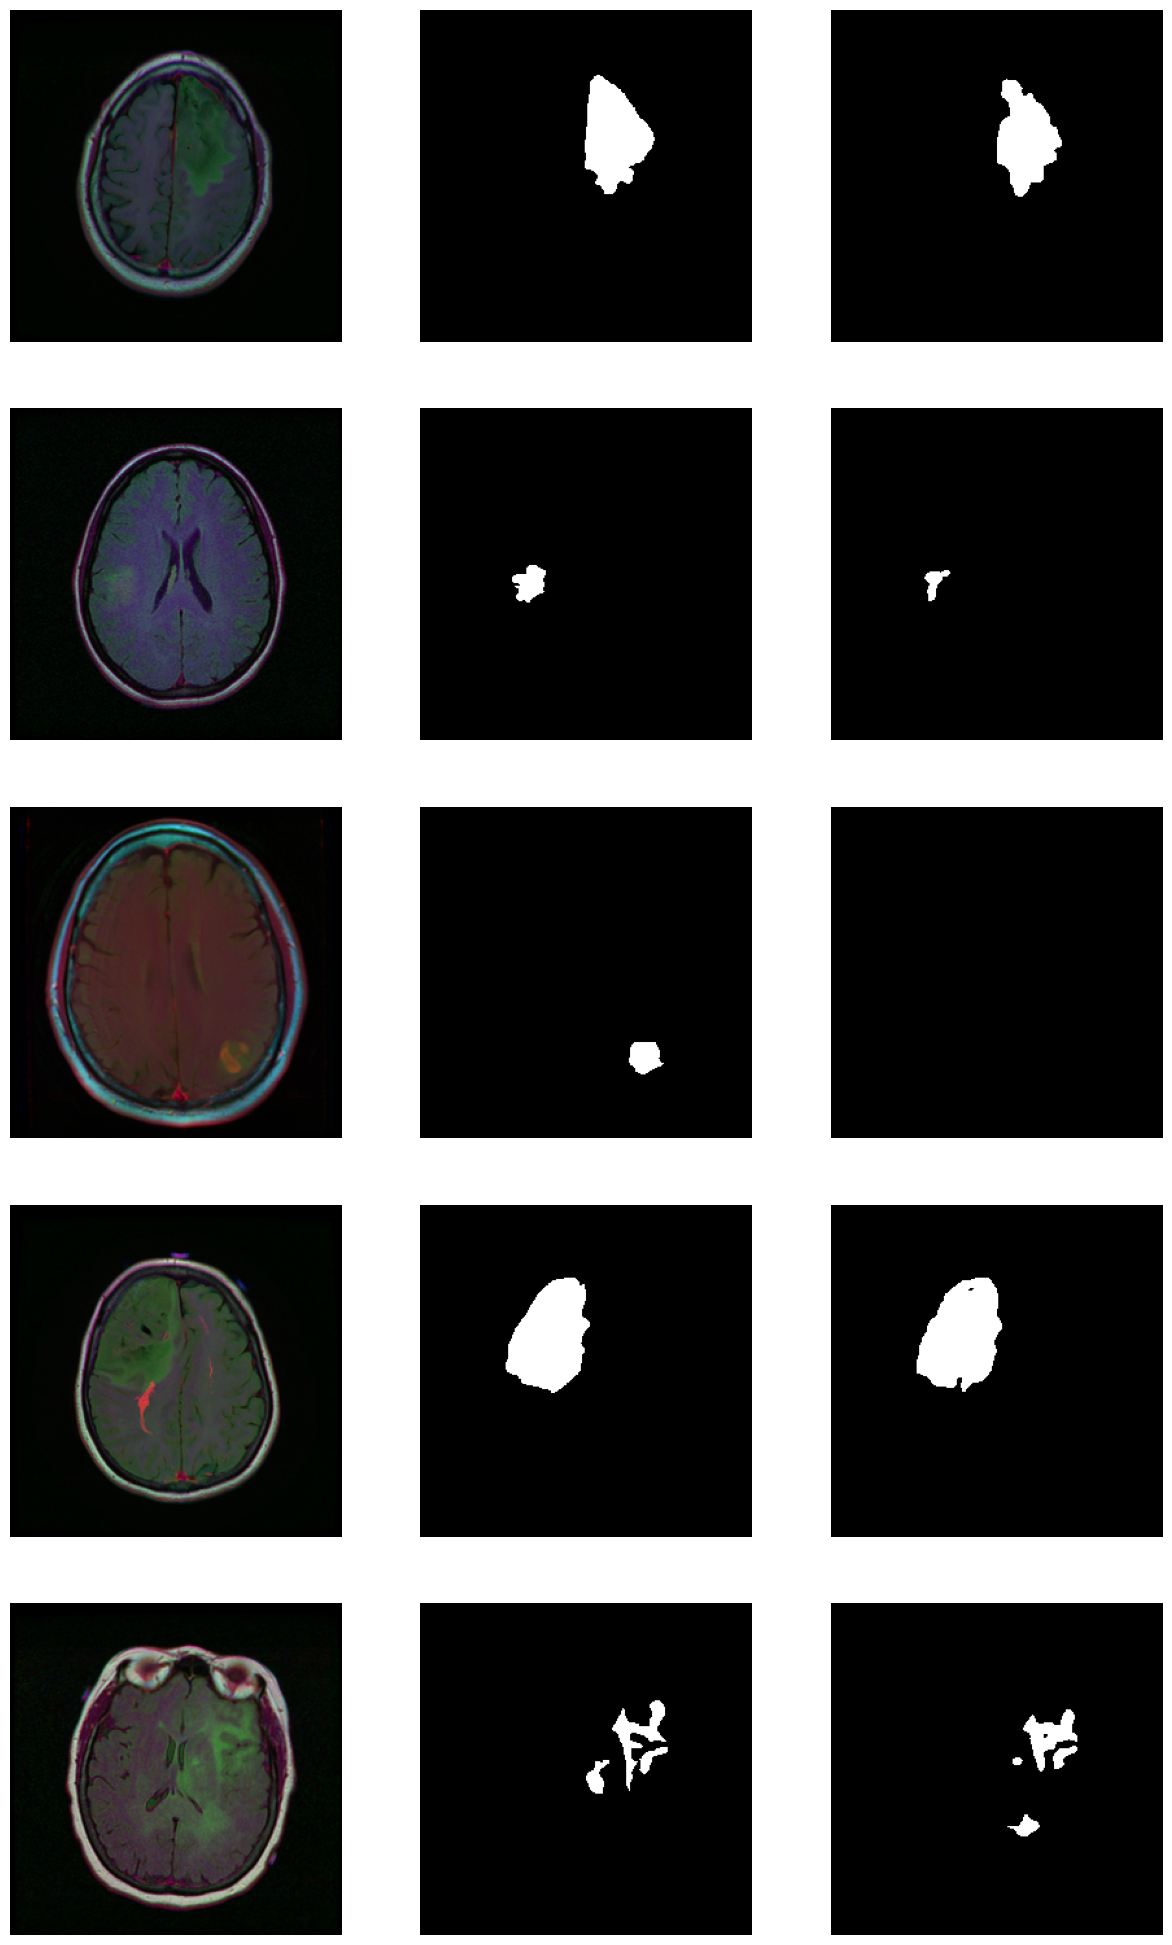

In [ ]:
selected_routes=brain_df_mask_test.sample(5)

plt.figure(figsize=(15,25))
for i in range(len(selected_routes)):

  plt.subplot(5,3,1+3*(i))
  image = cv2.cvtColor(io.imread(selected_routes.image_path.iloc[i]), cv2.COLOR_BGR2RGB)/255
  plt.imshow(image)
  plt.axis('off')

  plt.subplot(5,3,2+3*(i))
  true_mask = cv2.cvtColor(io.imread(selected_routes.mask_path.iloc[i]), cv2.COLOR_BGR2RGB)/255
  plt.imshow(true_mask)
  plt.axis('off')


  plt.subplot(5,3,3+3*(i))
  pred_mask=model_seg.predict(np.expand_dims(image, axis=0))[0]
  pred_mask = (pred_mask > 0.5).astype(np.uint8)
  plt.imshow(pred_mask, cmap='gray')
  plt.axis('off')


In [ ]:
# Generate predictions for all test images
image_id = []
mask = []
has_mask = []

print("Generating predictions for test set...")
for i in range(len(brain_df_mask_test)):
    # Get image path
    img_path = brain_df_mask_test.image_path.iloc[i]

    # Read and preprocess image
    image = cv2.cvtColor(io.imread(img_path), cv2.COLOR_BGR2RGB) / 255.0

    # Predict mask
    pred_mask = loaded_model_seg.predict(np.expand_dims(image, axis=0), verbose=0)[0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)

    # Store results
    image_id.append(img_path)
    mask.append(pred_mask)
    has_mask.append(1)  # All images in brain_df_mask_test have masks

    if (i + 1) % 20 == 0:
        print(f"Processed {i + 1}/{len(brain_df_mask_test)} images")

print(f"Completed! Generated predictions for {len(image_id)} images.")

Generating predictions for test set...
Processed 20/137 images
Processed 40/137 images
Processed 60/137 images
Processed 80/137 images
Processed 100/137 images
Processed 120/137 images
Completed! Generated predictions for 137 images.


In [ ]:
# creating a dataframe for the result
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred

image_path  \
0    ./data/TCGA_DU_7010_19860307/TCGA_DU_7010_1986...   
1    ./data/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_1997...   
2    ./data/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_1997...   
3    ./data/TCGA_DU_7018_19911220/TCGA_DU_7018_1991...   
4    ./data/TCGA_DU_8168_19970503/TCGA_DU_8168_1997...   
..                                                 ...   
132  ./data/TCGA_HT_7884_19980913/TCGA_HT_7884_1998...   
133  ./data/TCGA_DU_5871_19941206/TCGA_DU_5871_1994...   
134  ./data/TCGA_HT_8107_19980708/TCGA_HT_8107_1998...   
135  ./data/TCGA_DU_7300_19910814/TCGA_DU_7300_1991...   
136  ./data/TCGA_HT_7860_19960513/TCGA_HT_7860_1996...   

                                        predicted_mask  has_mask  
0    [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
1    [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
2    [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
3    [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
4    [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
..                                                 ...       ...  
132  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
133  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
134  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
135  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
136  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  

[137 rows x 3 columns]

In [ ]:
# Merge the dataframe containing predicted results with the original test data.
df_pred = brain_df_mask_test.merge(df_pred, on='image_path')
df_pred.head()

image_path  \
0  ./data/TCGA_DU_7010_19860307/TCGA_DU_7010_1986...   
1  ./data/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_1997...   
2  ./data/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_1997...   
3  ./data/TCGA_DU_7018_19911220/TCGA_DU_7018_1991...   
4  ./data/TCGA_DU_8168_19970503/TCGA_DU_8168_1997...   

                                           mask_path  mask  \
0  ./data/TCGA_DU_7010_19860307/TCGA_DU_7010_1986...     1   
1  ./data/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_1997...     1   
2  ./data/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_1997...     1   
3  ./data/TCGA_DU_7018_19911220/TCGA_DU_7018_1991...     1   
4  ./data/TCGA_DU_8168_19970503/TCGA_DU_8168_1997...     1   

                                      predicted_mask  has_mask  
0  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
1  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
2  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
3  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
4  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1

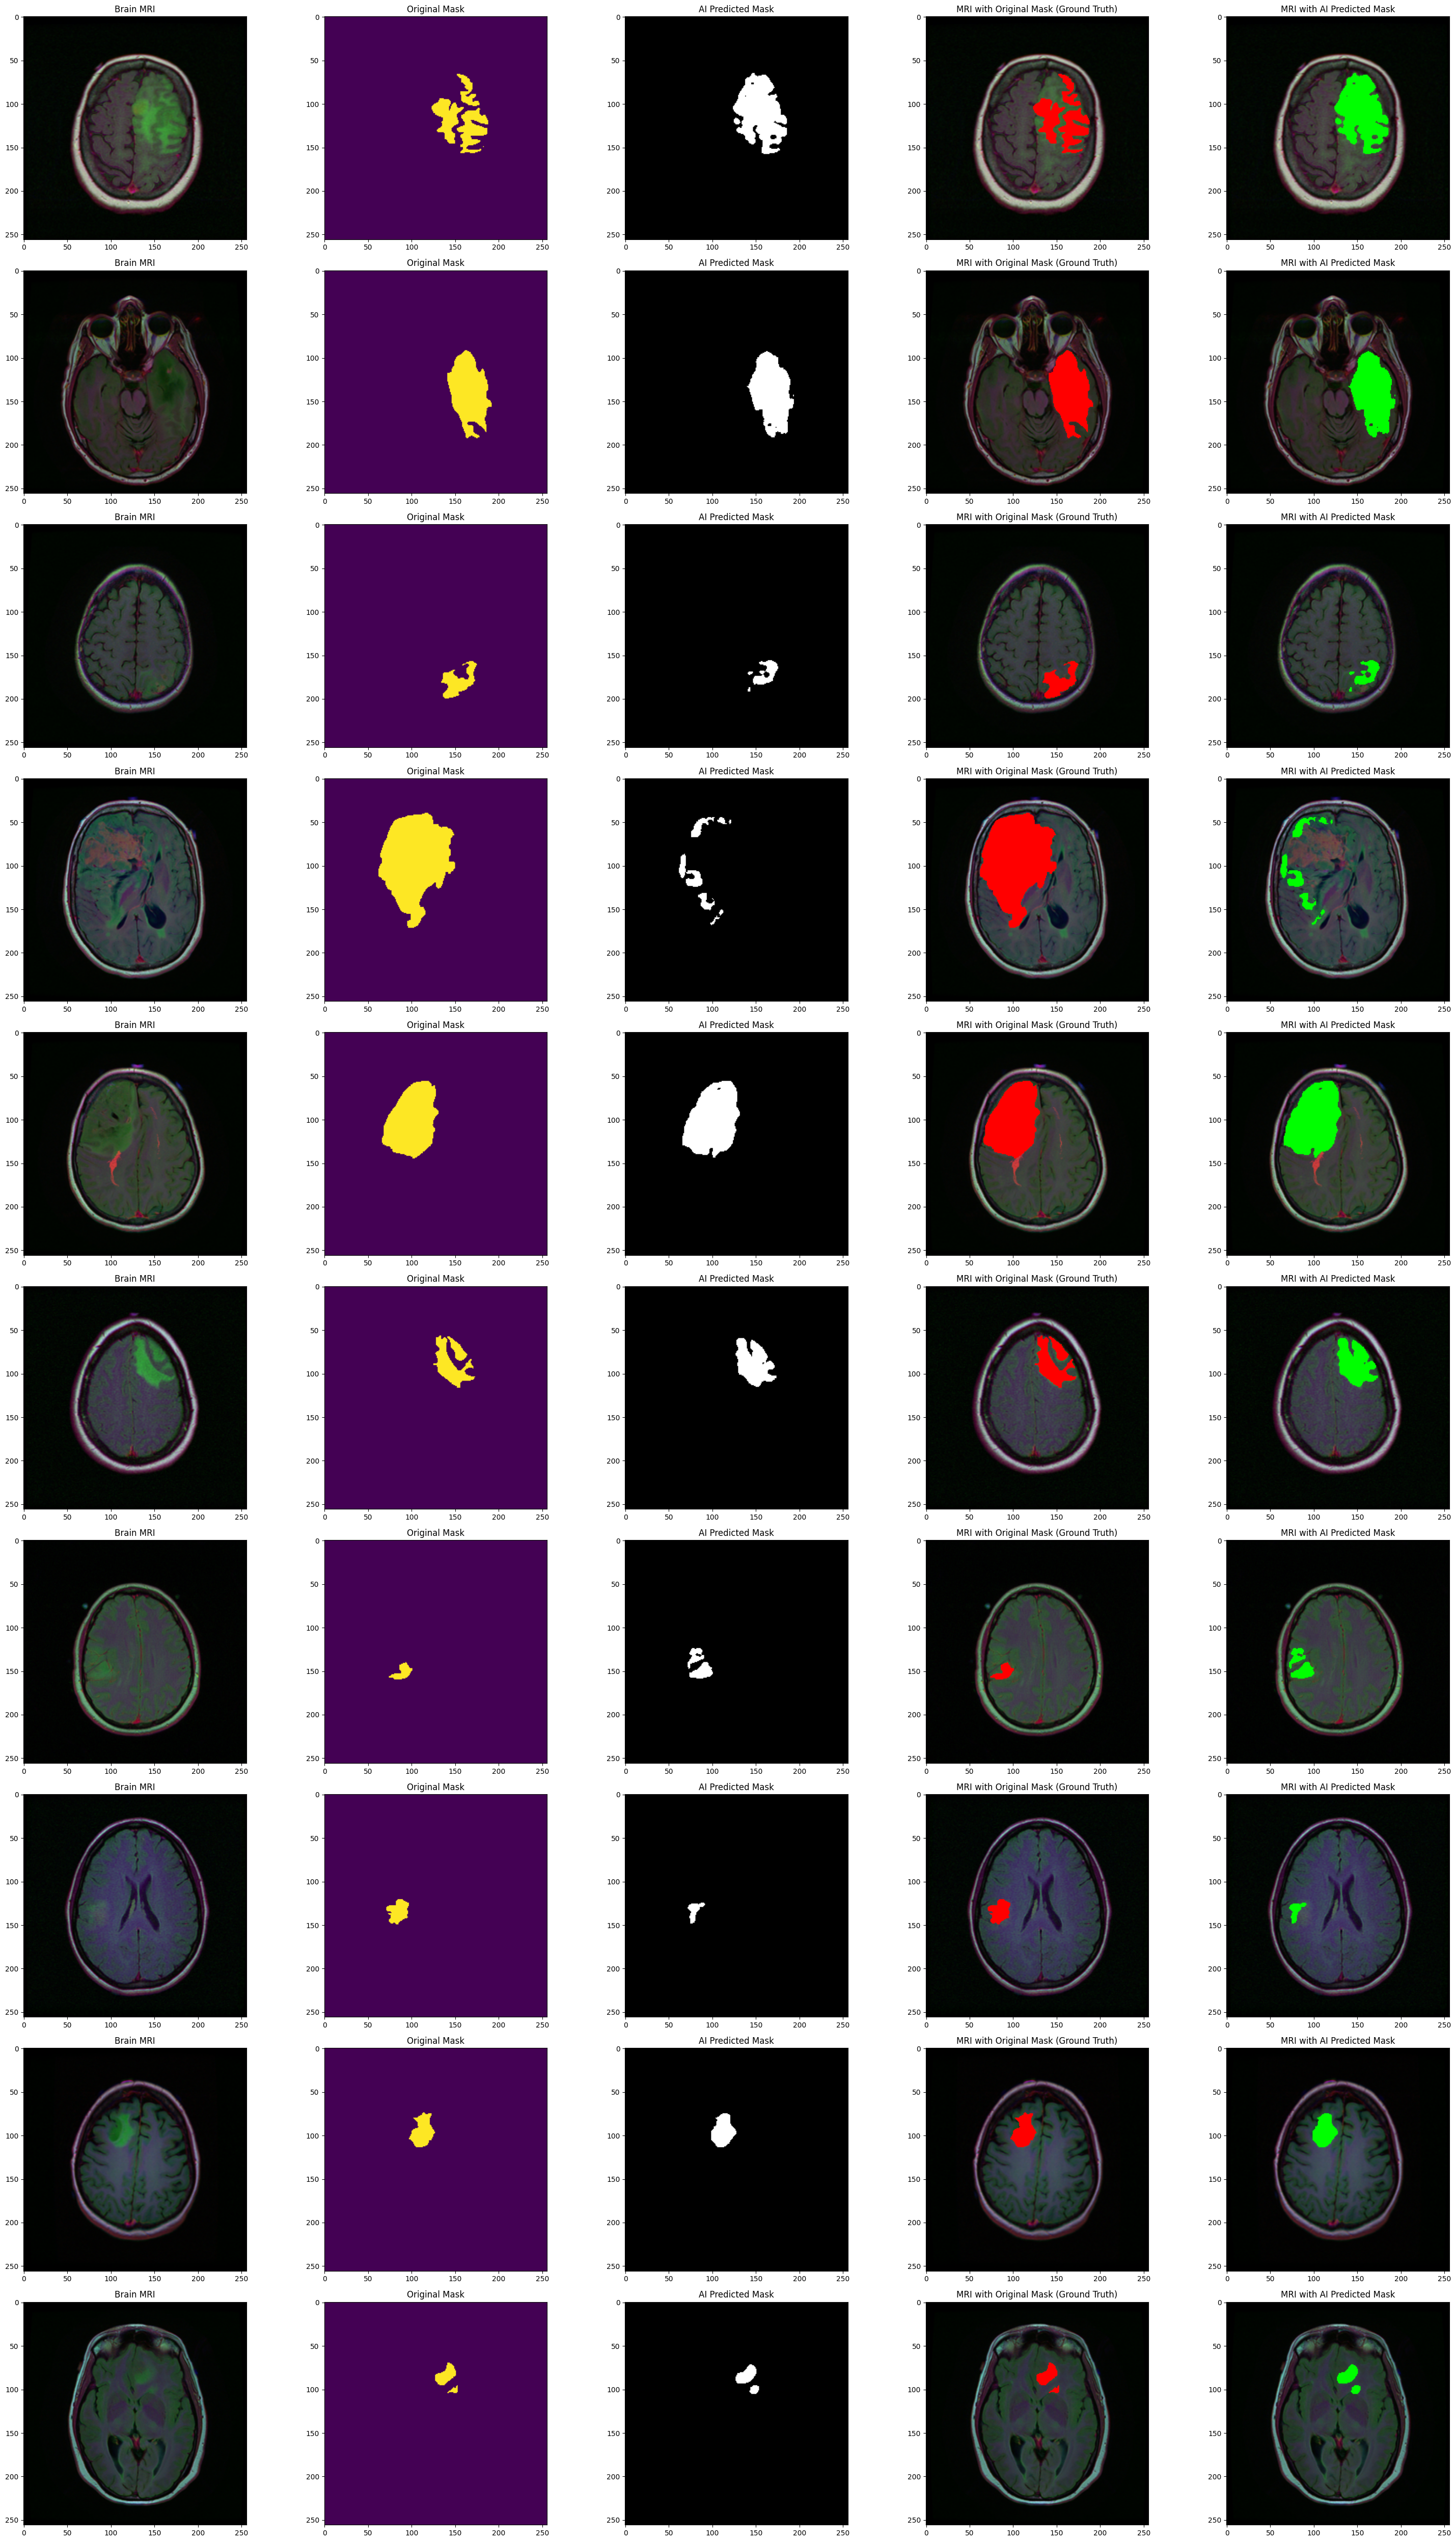

In [ ]:
count = 0
fig, axs = plt.subplots(10, 5, figsize=(30, 50))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 10:
    img = io.imread(df_pred.image_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    mask = io.imread(df_pred.mask_path[i])
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(mask)

    predicted_mask = np.array(df_pred.predicted_mask[i])
    if predicted_mask.ndim > 2:
        predicted_mask = predicted_mask.squeeze()
    if predicted_mask.ndim == 1:
        predicted_mask = predicted_mask.reshape(256, 256)
    predicted_mask = predicted_mask.round().astype(np.uint8)
    axs[count][2].title.set_text("AI Predicted Mask")
    axs[count][2].imshow(predicted_mask, cmap='gray')

    img[mask == 255] = (255, 0, 0)
    axs[count][3].title.set_text("MRI with Original Mask (Ground Truth)")
    axs[count][3].imshow(img)

    img_ = io.imread(df_pred.image_path[i])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axs[count][4].title.set_text("MRI with AI Predicted Mask")
    axs[count][4].imshow(img_)
    count += 1

fig.tight_layout()

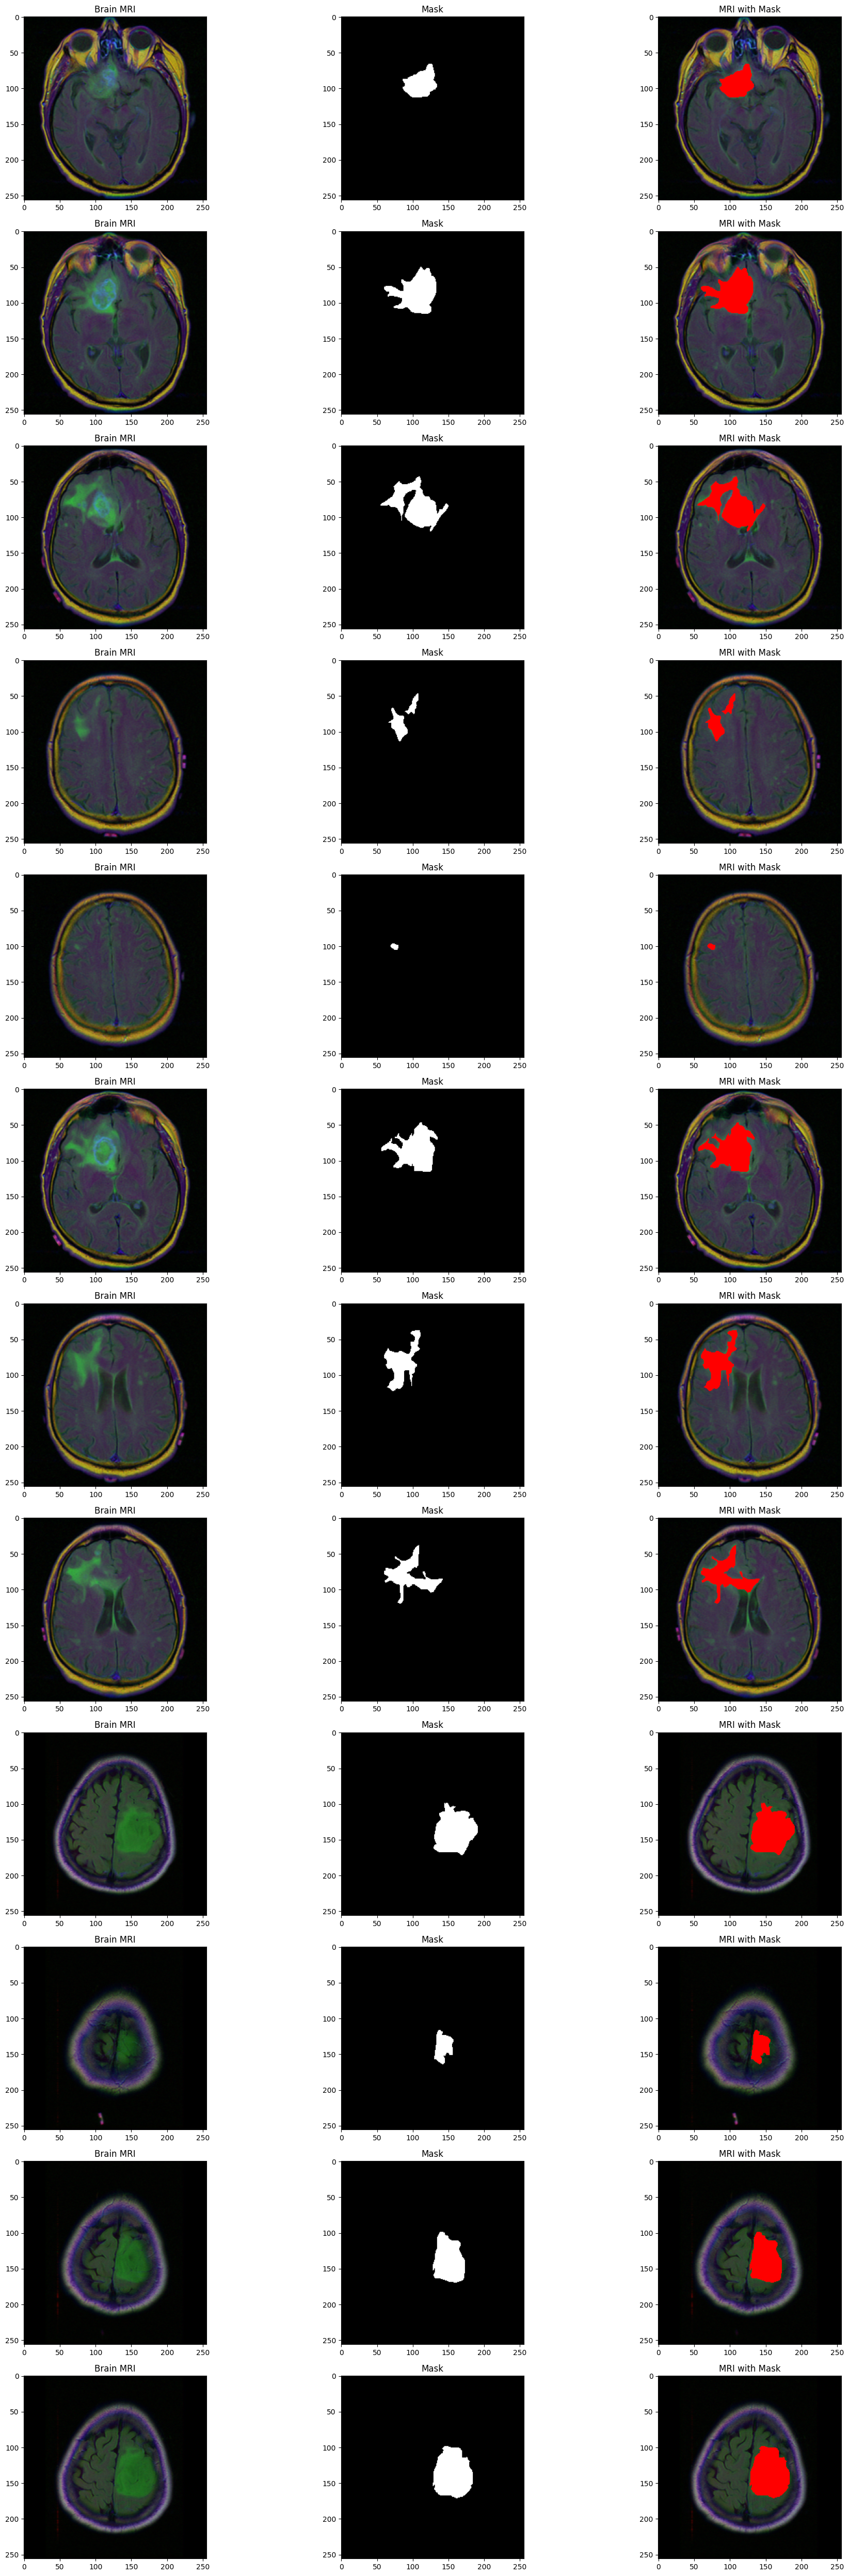

In [ ]:
# Advanced Visualization: visualize the MRI scans along with their mask on one image
count = 0
fig, axs = plt.subplots(12,3, figsize=(20,50))
for i in range(len(brain_df)):
  if brain_df['mask'][i] == 1 and count < 12:
  # read the images
    img = io.imread(brain_df.image_path[i])
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # obtain the mask for the image
    mask = io.imread(brain_df.mask_path[i])
    axs[count][1].title.set_text("Mask")
    axs[count][1].imshow(mask, cmap = 'gray')

    # replace the values in the image with red color (255,0,0) if any mask pixel in the mask was = 255
    img[mask == 255] = (255,0,0)
    axs[count][2].title.set_text("MRI with Mask")
    axs[count][2].imshow(img)
    count += 1

fig.tight_layout()

In [ ]:

from sklearn.metrics import classification_report

report = classification_report(original,predict, labels = [0,1])
print(report)